In [159]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

In [160]:
# Read in all orders.
orders = pd.read_csv('superstore_dataset2011-2015.csv', header=0, encoding='ISO-8859-1')

In [161]:
# Display dataset's data types.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [162]:
orders = orders.drop_duplicates()

In [163]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [6]:
# Dsiplay the dataset's number of rows and columns pre-formatting
orders.shape

(51290, 24)

In [7]:
# Display the dataset's basic stat.
orders.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [8]:
# Checking for null fields
df_null = round(100*(orders.isnull().sum())/len(orders), 2)
df_null

Row ID             0.00
Order ID           0.00
Order Date         0.00
Ship Date          0.00
Ship Mode          0.00
Customer ID        0.00
Customer Name      0.00
Segment            0.00
City               0.00
State              0.00
Country            0.00
Postal Code       80.51
Market             0.00
Region             0.00
Product ID         0.00
Category           0.00
Sub-Category       0.00
Product Name       0.00
Sales              0.00
Quantity           0.00
Discount           0.00
Profit             0.00
Shipping Cost      0.00
Order Priority     0.00
dtype: float64

In [9]:
# Drop Postal Code, since 80% of this column's data is missing
orders = orders.drop(columns=['Postal Code'])

In [10]:
orders = orders.dropna()

# Check the shape after dropping the rows with missing values
orders.shape

(51290, 23)

# RFM

In [158]:
# Monetary column
rfm_m = orders.groupby('Customer ID', 'City')['Sales'].sum()


ValueError: No axis named City for object type DataFrame

In [155]:
rfm_m

Customer ID
AA-10315    13747.41300
AA-10375     5884.19500
AA-10480    17695.58978
AA-10645    15343.89070
AA-315       2243.25600
               ...     
YS-21880    18703.60600
ZC-11910        7.17300
ZC-21910    28472.81926
ZD-11925     2951.22600
ZD-21925     9479.34440
Name: Sales, Length: 1590, dtype: float64

In [153]:
# Frequency column
rfm_f = orders.groupby('City','Customer ID')['Order ID'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['City','Customer ID', 'Frequency']
rfm_f.head()

ValueError: No axis named Customer ID for object type DataFrame

In [11]:
# Recency column
orders['Order Date'] = orders['Order Date'].str.replace('/', '-')
orders['Order Date']


0          1-1-2011
1          1-1-2011
2          1-1-2011
3          1-1-2011
4          1-1-2011
            ...    
51285    31-12-2014
51286    31-12-2014
51287    31-12-2014
51288    31-12-2014
51289    31-12-2014
Name: Order Date, Length: 51290, dtype: object

In [12]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'],format='%d-%m-%Y')
orders['Order Date']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
51285   2014-12-31
51286   2014-12-31
51287   2014-12-31
51288   2014-12-31
51289   2014-12-31
Name: Order Date, Length: 51290, dtype: datetime64[ns]

In [13]:
max_date = max(orders['Order Date'])
max_date

Timestamp('2014-12-31 00:00:00')

In [14]:
orders['Diff'] = max_date - orders['Order Date']
rfm_r = orders.groupby('Customer ID')['Diff'].min()
rfm_r = rfm_r.reset_index().sort_values(by='Diff', ascending=False)
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

,Customer ID,Diff
431,DK-2985,1206
484,DW-3195,1063
1460,SZ-10035,956
850,KD-6270,811
365,CT-1995,783
...,...,...
871,KL-6645,0
872,KM-16225,0
680,JA-15970,0
939,LP-7095,0


In [15]:
# Merging dataframes
rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_r, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,AA-10315,13747.41300,42,8
1,AA-10375,5884.19500,42,6
2,AA-10480,17695.58978,38,125
3,AA-10645,15343.89070,73,28
4,AA-315,2243.25600,8,2


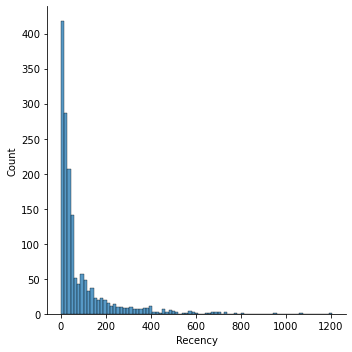

In [16]:
# Distribution for Recency
sns.displot(rfm['Recency'])

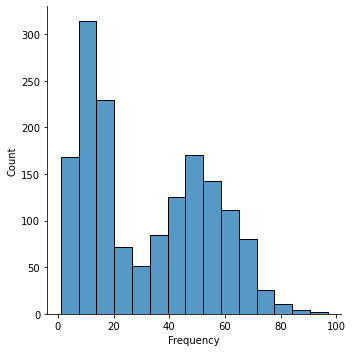

In [17]:
# Distribution for Frequency
sns.displot(rfm['Frequency'])

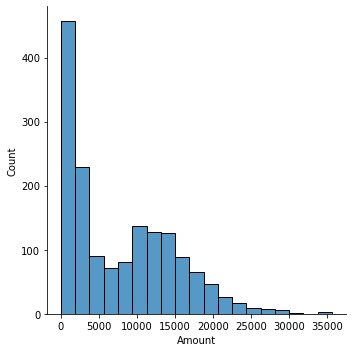

In [18]:
# Distribution for Amount
sns.displot(rfm['Amount'])

Text(0.5, 0, 'Attributes')

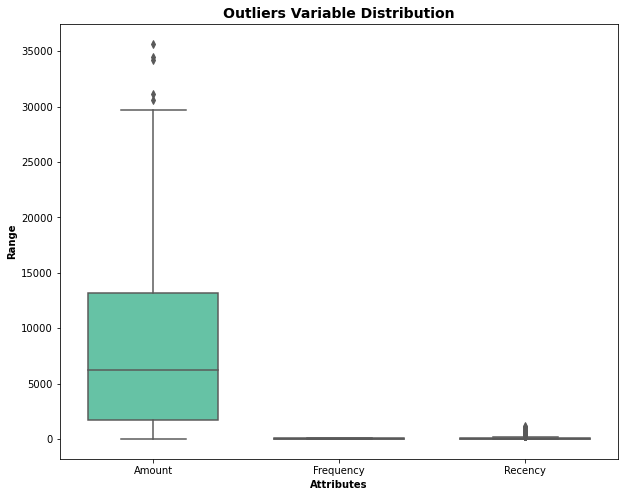

In [19]:
# Detect outliers

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [20]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

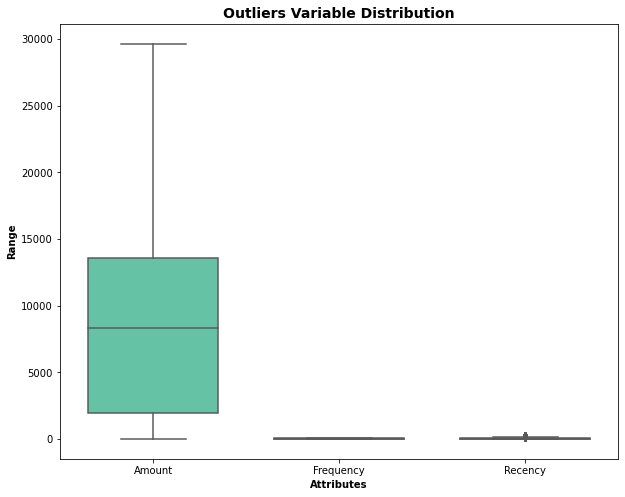

In [21]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

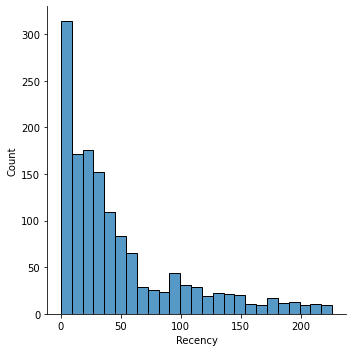

In [22]:
# Distribution for Recency
sns.displot(rfm['Recency'])

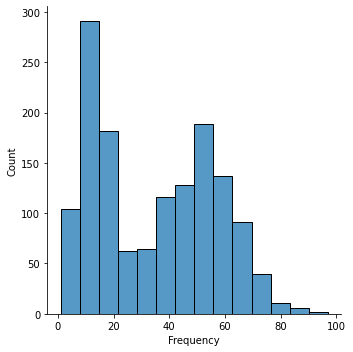

In [23]:
# Distribution for Frequency
sns.displot(rfm['Frequency'])

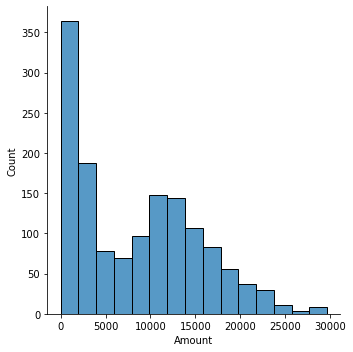

In [24]:
# Distribution for Amount
sns.displot(rfm['Amount'])

In [25]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = MinMaxScaler()
# Compare with Standardization

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(1423, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.463304,0.427083,0.035398
1,0.198166,0.427083,0.026549
2,0.596432,0.385417,0.553097
3,0.517136,0.750000,0.123894
4,0.075398,0.072917,0.008850


In [27]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([0, 0, 0, ..., 2, 3, 0])

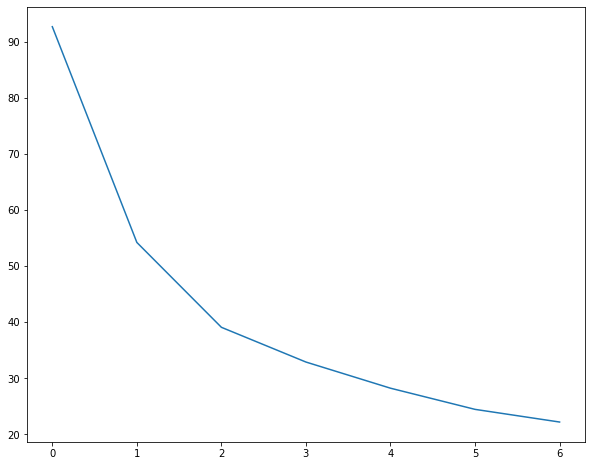

In [29]:
# Elbow-curve/SSD (Sum of Squares Distance)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [30]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.5211722951221243
For n_clusters=3, the silhouette score is 0.5229832676402274
For n_clusters=4, the silhouette score is 0.4448551021692008
For n_clusters=5, the silhouette score is 0.41997028205007814
For n_clusters=6, the silhouette score is 0.41504544677728317
For n_clusters=7, the silhouette score is 0.3830486542365985
For n_clusters=8, the silhouette score is 0.3656454013449898


In [31]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([0, 0, 0, ..., 3, 2, 0])

In [33]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,13747.41300,42,8,0
1,AA-10375,5884.19500,42,6,0
2,AA-10480,17695.58978,38,125,0
3,AA-10645,15343.89070,73,28,3
4,AA-315,2243.25600,8,2,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

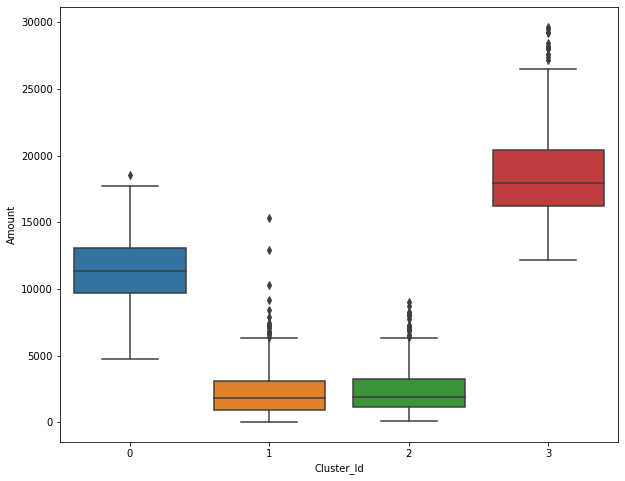

In [34]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

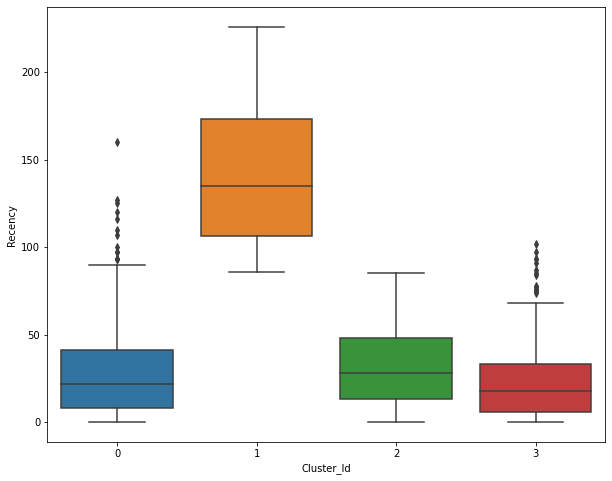

In [35]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

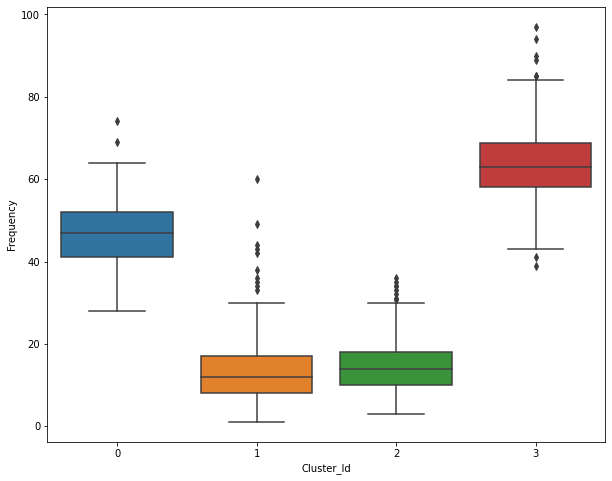

In [36]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

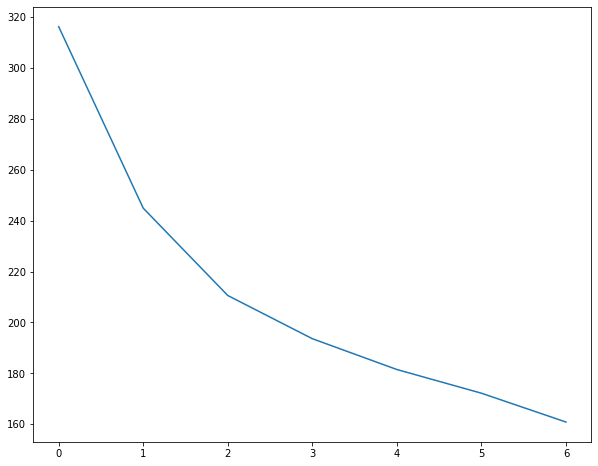

In [37]:
# Elbow-curve/SSD (Sum of Squares Distance)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(rfm_df_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [38]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(rfm_df_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.5203913617673406
For n_clusters=3, the silhouette score is 0.5250633330932897
For n_clusters=4, the silhouette score is 0.443060957404447
For n_clusters=5, the silhouette score is 0.4239865934219881
For n_clusters=6, the silhouette score is 0.36401681622518356
For n_clusters=7, the silhouette score is 0.3711365989889908
For n_clusters=8, the silhouette score is 0.3221283698603149


In [39]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50, method='pam')
kmedoids.fit(rfm_df_scaled)

KMedoids(max_iter=50, method='pam', n_clusters=4)

In [40]:
# assign the label
rfm['Cluster_Id'] = kmedoids.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,13747.41300,42,8,1
1,AA-10375,5884.19500,42,6,1
2,AA-10480,17695.58978,38,125,0
3,AA-10645,15343.89070,73,28,0
4,AA-315,2243.25600,8,2,3


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

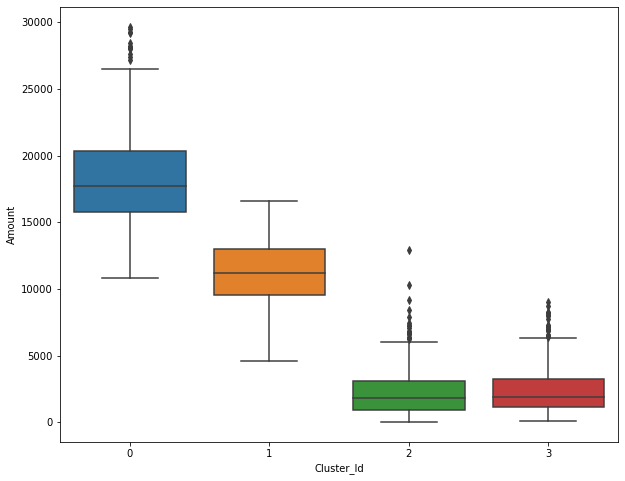

In [41]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

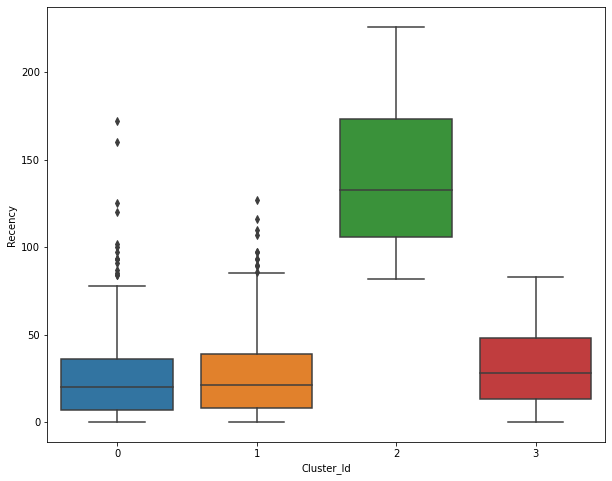

In [42]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

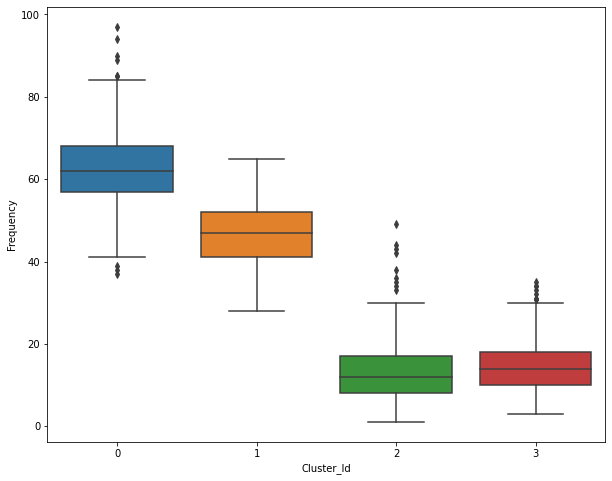

In [44]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# Profit-Sales-ShippingCost

In [164]:
# Profit column
profit_column = orders.groupby('City')['Profit'].sum()
profit_column = profit_column.reset_index()
profit_column.columns = ['City', 'Profit']
profit_column.head()

,City,Profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820


In [165]:
# Sales column
sales_column = orders.groupby('City')['Sales'].sum()
sales_column = sales_column.reset_index()
sales_column.columns = ['City', 'Sales']
sales_column.head()

,City,Sales
0,Aachen,3803.151
1,Aalen,979.695
2,Aalst,387.330
3,Aba,1064.124
4,Abadan,1354.950


In [166]:
# Shipping Cost column
shippingCost_column = orders.groupby('City')['Shipping Cost'].sum()
shippingCost_column = shippingCost_column.reset_index()
shippingCost_column.columns = ['City', 'ShippingCost']
shippingCost_column.head()

,City,ShippingCost
0,Aachen,391.28
1,Aalen,81.97
2,Aalst,30.19
3,Aba,122.45
4,Abadan,116.22


In [167]:
# Merging dataframes
profit_sales = pd.merge(profit_column, sales_column, on='City', how='inner')
profit_sales_shippingCost = pd.merge(profit_sales, shippingCost_column, on='City', how='inner')
profit_sales_shippingCost.columns = ['City', 'Profit', 'Sales', 'ShippingCost']
profit_sales_shippingCost.head()

,City,Profit,Sales,ShippingCost
0,Aachen,1116.981,3803.151,391.28
1,Aalen,283.005,979.695,81.97
2,Aalst,152.310,387.330,30.19
3,Aba,-1475.556,1064.124,122.45
4,Abadan,233.820,1354.950,116.22


Text(0.5, 0, 'Attributes')

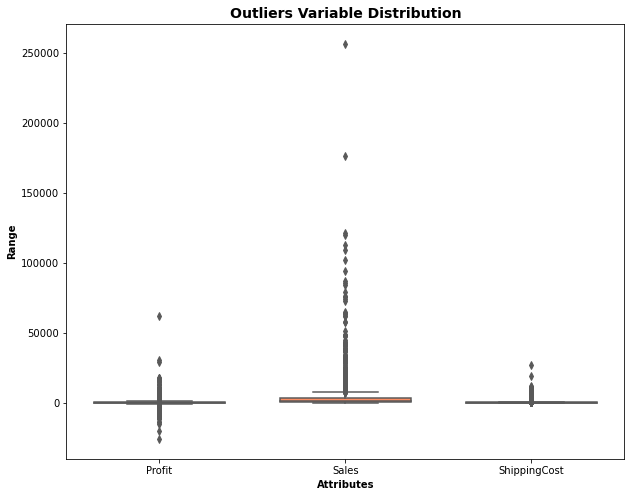

In [168]:
# Detect outliers

attributes = ['Profit','Sales','ShippingCost']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = profit_sales_shippingCost[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

(-15000.0, 15000.0)

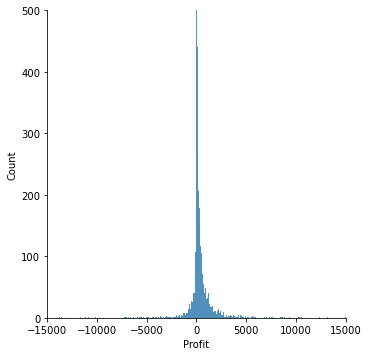

In [169]:
sns.displot(profit_sales_shippingCost['Profit'])
plt.ylim(0, 500)
plt.xlim(-15000, 15000)

(0.0, 15000.0)

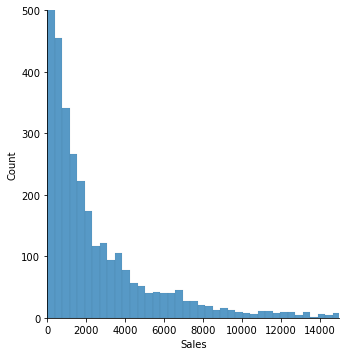

In [170]:
sns.displot(profit_sales_shippingCost['Sales'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

(0.0, 15000.0)

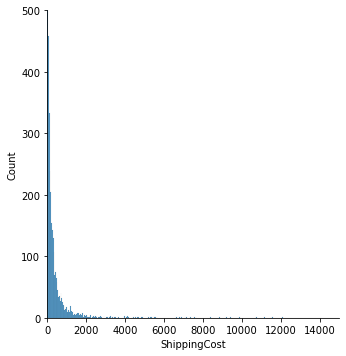

In [171]:
sns.displot(profit_sales_shippingCost['ShippingCost'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

In [172]:
# Removing (statistical) outliers for Sales
Q1 = profit_sales_shippingCost.Sales.quantile(0.25)
Q3 = profit_sales_shippingCost.Sales.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.Sales >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Shipping Cost
Q1 = profit_sales_shippingCost.ShippingCost.quantile(0.25)
Q3 = profit_sales_shippingCost.ShippingCost.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.ShippingCost >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.ShippingCost <= Q3 + 1.5*IQR)]

(-15000.0, 15000.0)

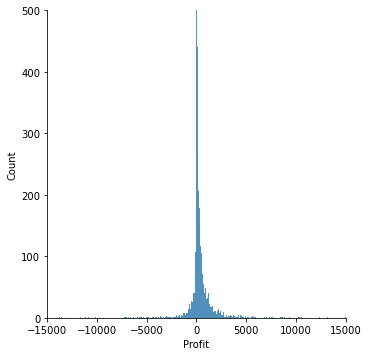

In [173]:
sns.displot(profit_sales_shippingCost['Profit'])
plt.ylim(0, 500)
plt.xlim(-15000, 15000)

(0.0, 15000.0)

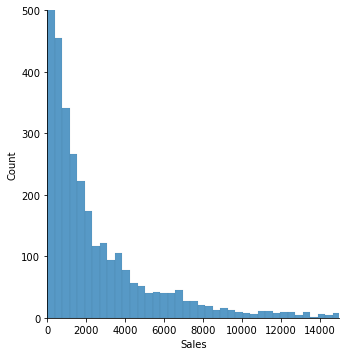

In [174]:
sns.displot(profit_sales_shippingCost['Sales'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

(0.0, 15000.0)

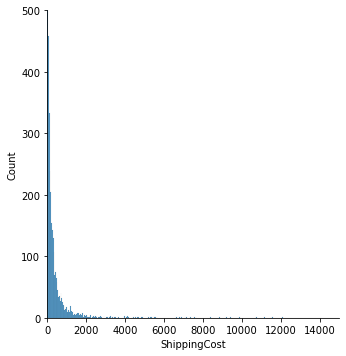

In [175]:
sns.displot(profit_sales_shippingCost['ShippingCost'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

In [176]:
# Rescaling the attributes

psc = profit_sales_shippingCost[['Profit', 'Sales', 'ShippingCost']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
psc_scaled = scaler.fit_transform(psc)
psc_scaled.shape

(3636, 3)

In [177]:
psc_scaled = pd.DataFrame(psc_scaled)
psc_scaled.columns = ['Profit', 'Sales', 'ShippingCost']
psc_scaled.head()

,Profit,Sales,ShippingCost
0,0.307408,0.014829,0.014516
1,0.297927,0.003816,0.003038
2,0.296441,0.001505,0.001117
3,0.277934,0.004145,0.004541
4,0.297368,0.005280,0.004309


Text(0, 0.5, 'Average within Cluster Sum Of Squares')

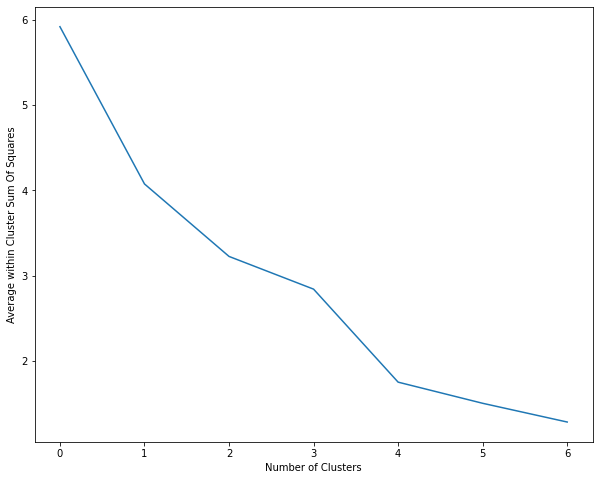

In [179]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, init='random', algorithm='elkan')
    kmeans.fit(psc_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [180]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, init='random', algorithm='elkan')
    kmeans.fit(psc_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.9303563385577867
For n_clusters=3, the silhouette score is 0.8247740621199919
For n_clusters=4, the silhouette score is 0.7083841380446546
For n_clusters=5, the silhouette score is 0.6275937650989983
For n_clusters=6, the silhouette score is 0.6855947899637531
For n_clusters=7, the silhouette score is 0.6208916381702443
For n_clusters=8, the silhouette score is 0.6003082813233102


In [200]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50, init='random', algorithm='elkan')
kmeans.fit(psc_scaled)

KMeans(algorithm='elkan', init='random', max_iter=50, n_clusters=4)

In [201]:
 kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [202]:
# assign the label
psc['Cluster_Id'] = kmeans.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,0
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

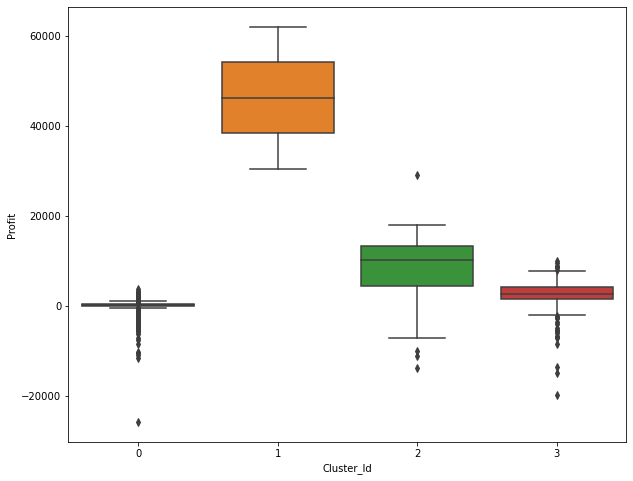

In [203]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

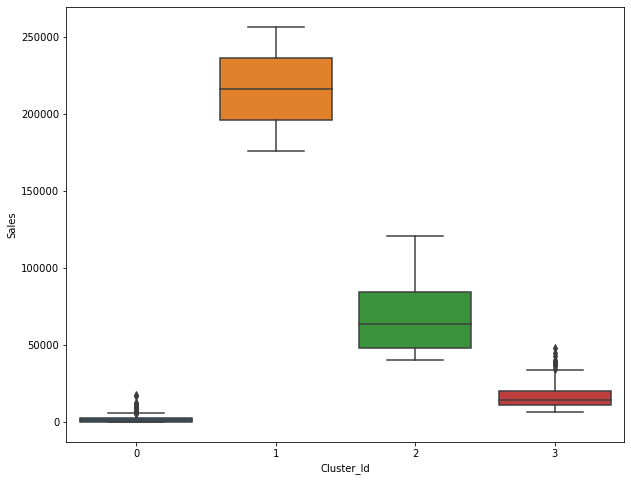

In [204]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

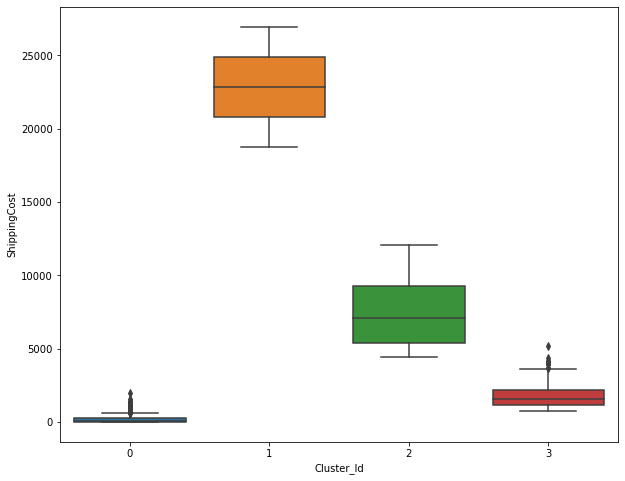

In [205]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

Text(0, 0.5, 'Average within Cluster Sum Of Squares')

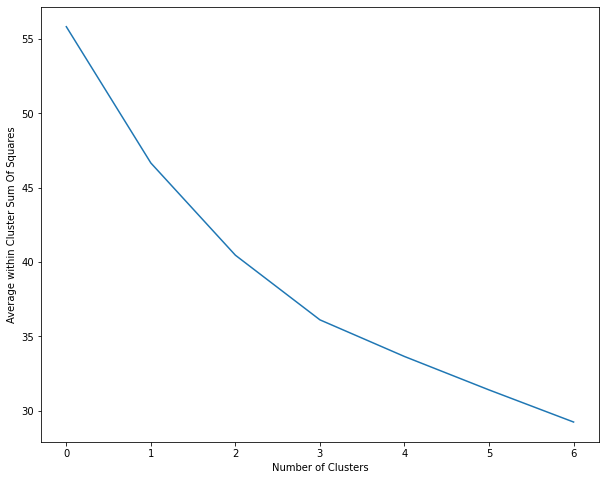

In [199]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(psc_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [27]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(psc_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.6278010736392924
For n_clusters=3, the silhouette score is 0.5926872496150054
For n_clusters=4, the silhouette score is 0.4648899175929373
For n_clusters=5, the silhouette score is 0.43888416557236487
For n_clusters=6, the silhouette score is 0.3431243511722141
For n_clusters=7, the silhouette score is 0.3535063035731479
For n_clusters=8, the silhouette score is 0.3986867827934289


In [28]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50, init='build', method='pam')
kmedoids.fit(psc_scaled)

KMedoids(init='build', max_iter=50, method='pam', n_clusters=4)

In [29]:
# assign the label
psc['Cluster_Id'] = kmedoids.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,3
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

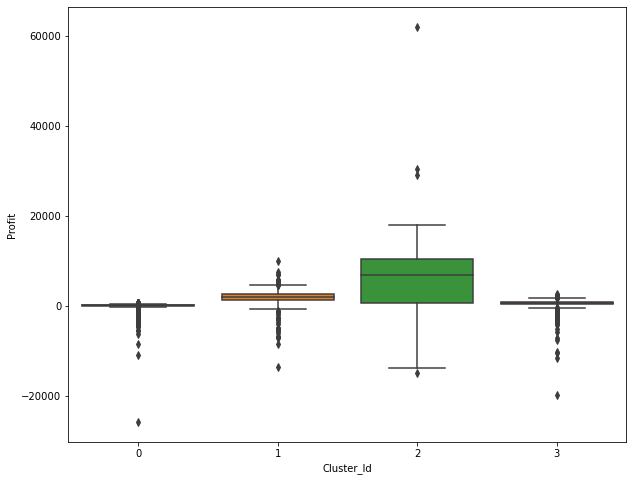

In [30]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

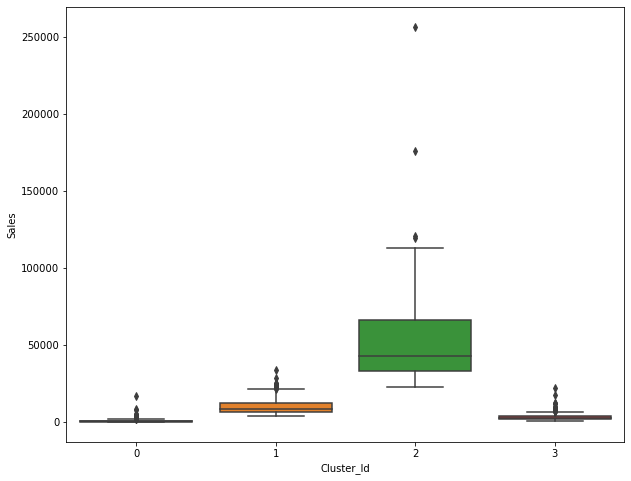

In [31]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

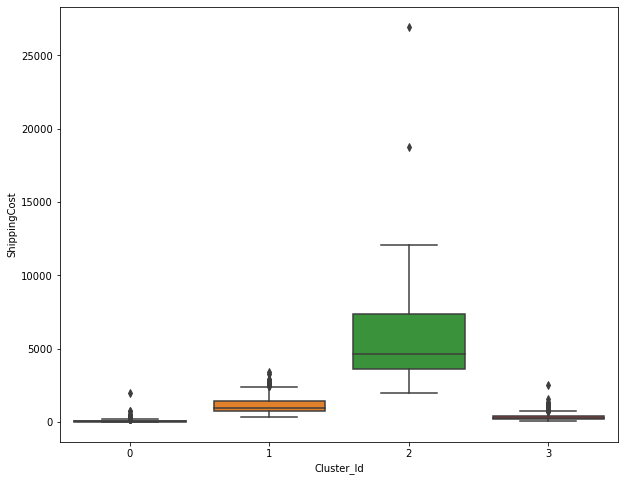

In [32]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

In [116]:
psc_0 = psc.loc[(psc['Cluster_Id'] == 2) & (psc['Profit'] > 1000)]

In [117]:
psc_0 = psc_0.sort_values(by=['ShippingCost'], ascending=False)

In [118]:
psc_0

,Profit,Sales,ShippingCost,Cluster_Id
2936,29156.09670,119540.74200,11581.45,2
3107,16002.80700,101945.51700,11183.66,2
2843,17507.38540,112669.09200,10753.24,2
1508,3826.98420,94321.32420,10735.47,2
1895,17378.71500,86945.80500,9890.22,2
1989,17853.71804,83707.49804,9393.94,2
2106,13342.29176,85728.55176,8860.27,2
1202,4453.78200,72626.92200,8824.94,2
497,10526.29500,75729.01500,8405.25,2
2082,11304.09960,73939.16400,7558.13,2


In [138]:
high_orders = profit_sales_shippingCost[profit_sales_shippingCost.index.isin(psc_0.index)].sort_values(by=['ShippingCost'], ascending=False)

In [139]:
high_orders

,City,Profit,Sales,ShippingCost
2936,Seattle,29156.09670,119540.74200,11581.45
3107,Sydney,16002.80700,101945.51700,11183.66
2843,San Francisco,17507.38540,112669.09200,10753.24
1508,Jakarta,3826.98420,94321.32420,10735.47
1895,London,17378.71500,86945.80500,9890.22
1989,Managua,17853.71804,83707.49804,9393.94
2106,Mexico City,13342.29176,85728.55176,8860.27
1202,Gold Coast,4453.78200,72626.92200,8824.94
497,Brisbane,10526.29500,75729.01500,8405.25
2082,Melbourne,11304.09960,73939.16400,7558.13


In [149]:
['Sales'].sum()

In [150]:
a

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Average within Cluster Sum Of Squares')

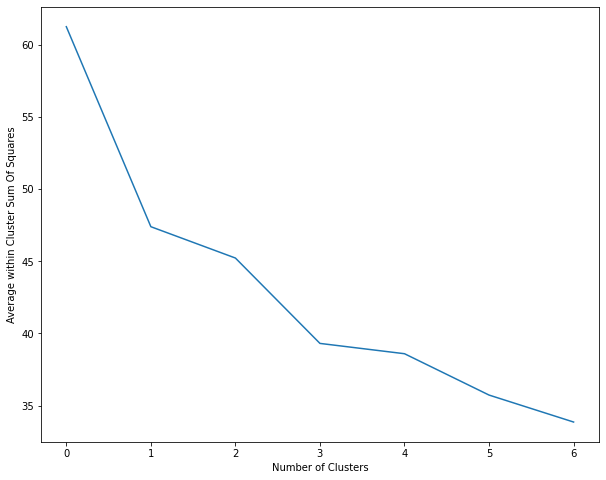

In [34]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, init='k-medoids++', method='alternate')
    kmedoids.fit(psc_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [35]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, init='k-medoids++', method='alternate')
    kmedoids.fit(psc_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.6637304846664962
For n_clusters=3, the silhouette score is 0.6201405608088065
For n_clusters=4, the silhouette score is 0.6134898882300464
For n_clusters=5, the silhouette score is 0.5563865031260716
For n_clusters=6, the silhouette score is 0.5674269329241214
For n_clusters=7, the silhouette score is 0.5980979718475006
For n_clusters=8, the silhouette score is 0.5570649678715257


In [82]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50, init='k-medoids++', method='alternate')
kmedoids.fit(psc_scaled)

KMedoids(init='k-medoids++', max_iter=50, n_clusters=4)

In [83]:
# assign the label
psc['Cluster_Id'] = kmedoids.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,1
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

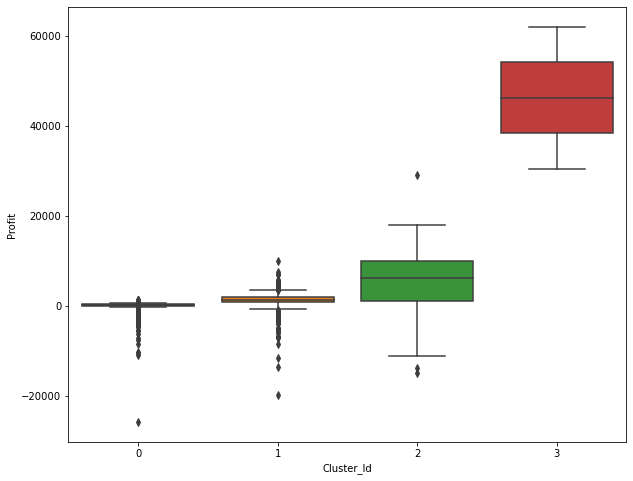

In [84]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

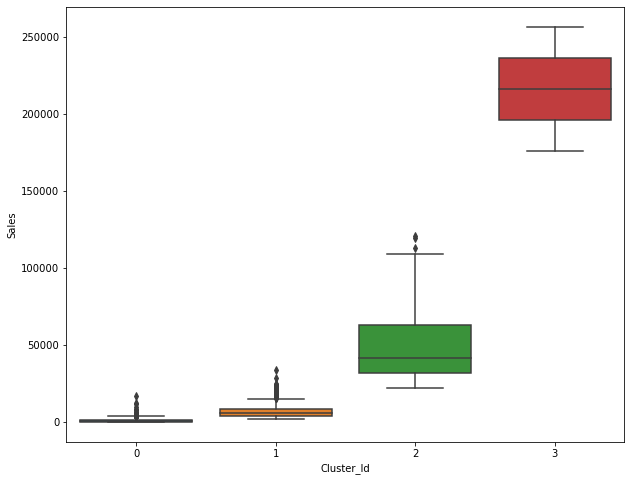

In [85]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

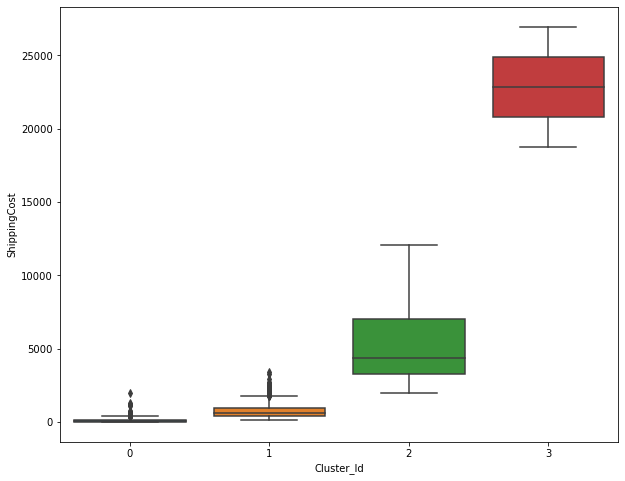

In [86]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

In [89]:
psc_0 = psc.loc[(psc['Cluster_Id'] == 3)]

In [90]:
psc_0.sort_values(by=['ShippingCost'], ascending=False)

,Profit,Sales,ShippingCost,Cluster_Id
2290,62036.9837,256368.161,26948.17,3
1910,30440.7579,175851.341,18777.07,3


In [91]:
profit_sales_shippingCost

,City,Profit,Sales,ShippingCost
0,Aachen,1116.981,3803.151,391.28
1,Aalen,283.005,979.695,81.97
2,Aalst,152.310,387.330,30.19
3,Aba,-1475.556,1064.124,122.45
4,Abadan,233.820,1354.950,116.22
...,...,...,...,...
3631,Zwedru,11.850,49.410,3.09
3632,Zwickau,19.380,99.030,7.31
3633,Zwolle,-55.095,150.585,24.38
3634,eMbalenhle,13.620,75.900,9.39


In [106]:
high_value_orders = orders[orders.index.isin(psc_0.index)]


In [109]:
high_value_orders 

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
26,15218,ES-2011-3893444,1/3/2011,5/3/2011,Standard Class,TB-21400,Tom Boeckenhauer,Consumer,Berlin,Berlin,...,OFF-AP-10002568,Office Supplies,Appliances,"Hamilton Beach Toaster, Black",364.4160,8,0.20,45.4560,80.67,High
70,21918,IN-2011-59986,1/3/2011,3/3/2011,First Class,KH-16360,Katherine Hughes,Consumer,Adelaide,South Australia,...,OFF-BI-10004436,Office Supplies,Binders,"Acco Hole Reinforcements, Recycled",12.6360,2,0.10,-1.1640,1.05,High
248,21082,ID-2011-77619,1/11/2011,2/11/2011,First Class,MK-18160,Mike Kennedy,Consumer,Seoul,Seoul,...,OFF-AP-10002882,Office Supplies,Appliances,"KitchenAid Coffee Grinder, Silver",142.4400,4,0.50,-25.6800,30.95,Critical
291,44461,AL-2011-4500,1/11/2011,5/11/2011,Standard Class,EM-3825,Elizabeth Moffitt,Corporate,Korce,Korçë,...,OFF-AVE-10002892,Office Supplies,Binders,"Avery 3-Hole Punch, Recycled",28.2300,1,0.00,0.0000,1.94,Medium
337,41701,NI-2011-1760,1/12/2011,3/12/2011,Second Class,FG-4260,Frank Gastineau,Home Office,Ibadan,Oyo,...,OFF-ADV-10002549,Office Supplies,Fasteners,"Advantus Rubber Bands, Assorted Sizes",25.2720,6,0.70,-40.6080,3.10,High
375,10718,ES-2011-1640672,2/2/2011,5/2/2011,First Class,KH-16630,Ken Heidel,Corporate,Dresden,Saxony,...,OFF-PA-10000908,Office Supplies,Paper,"Xerox Note Cards, Premium",13.1850,1,0.50,-7.9350,1.83,High
497,26112,IN-2011-52125,2/8/2011,3/8/2011,First Class,RH-19495,Rick Hansen,Consumer,Shangzhi,Heilongjiang,...,FUR-CH-10000110,Furniture,Chairs,"Hon Bag Chairs, Red",90.3000,2,0.00,38.8200,22.38,High
554,49885,CG-2011-6740,2/9/2011,3/9/2011,First Class,SO-10335,Sean O'Donnell,Consumer,Kinshasa,Kinshasa,...,OFF-HON-10001102,Office Supplies,Labels,"Hon Legal Exhibit Labels, Adjustable",35.0400,4,0.00,5.5200,10.30,High
613,47196,TU-2011-3090,2/11/2011,6/11/2011,Standard Class,FH-4350,Fred Harton,Consumer,Mersin,Mersin,...,TEC-MOT-10001950,Technology,Phones,"Motorola Headset, Full Size",64.8240,2,0.60,-61.5960,5.51,Medium
771,47551,CG-2011-9150,3/5/2011,7/5/2011,Standard Class,EH-3990,Erica Hackney,Consumer,Kisangani,Orientale,...,OFF-ELD-10000024,Office Supplies,Storage,"Eldon Folders, Blue",16.9800,1,0.00,2.8800,1.21,High
